# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
import numpy as np
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

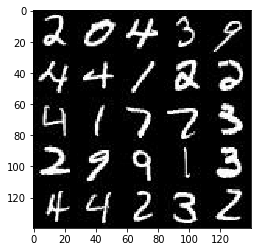

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

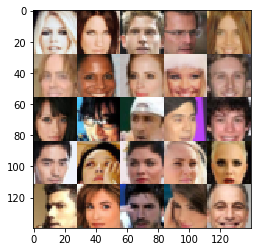

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Placeholders
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/upgrade/miniconda3/envs/dl/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/upgrade/miniconda3/envs/dl/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/upgrade/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/upgrade/miniconda3/envs/dl/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/upgrade/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/upgrade/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Disciminator model
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, 
                                 strides=2, 
                                 padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))
        relu1 = tf.maximum(0.2 * conv1, conv1)
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, 
                                 strides=2, 
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, 
                                 strides=2, 
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        dropout = tf.nn.dropout(flat,0.3)
        logits = tf.layers.dense(dropout, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Generator model
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.1 * x1, x1)
        
        upsample = tf.image.resize_nearest_neighbor(x1, (7,7))
        x2 = tf.layers.conv2d_transpose(upsample, 64, 5, 
                                        strides=1, 
                                        padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.1 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, 
                                        strides=2, 
                                        padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.1 * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 
                                            strides=2, 
                                            padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake) * np.random.uniform(0.0, 0.3)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt= model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode)
                    
    print("Finish training")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.8912... Generator Loss: 0.0370
Epoch 1/2... Discriminator Loss: 0.9336... Generator Loss: 1.7542
Epoch 1/2... Discriminator Loss: 0.5361... Generator Loss: 3.8713
Epoch 1/2... Discriminator Loss: 1.3180... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 2.2848... Generator Loss: 0.3244
Epoch 1/2... Discriminator Loss: 2.3858... Generator Loss: 0.3410
Epoch 1/2... Discriminator Loss: 3.2803... Generator Loss: 0.1469
Epoch 1/2... Discriminator Loss: 2.6768... Generator Loss: 0.1502
Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 0.5492
Epoch 1/2... Discriminator Loss: 1.7026... Generator Loss: 0.4082


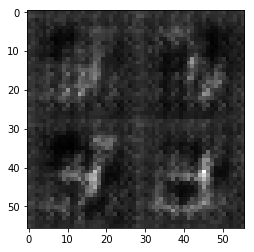

Epoch 1/2... Discriminator Loss: 1.9018... Generator Loss: 0.3648
Epoch 1/2... Discriminator Loss: 2.2273... Generator Loss: 0.2560
Epoch 1/2... Discriminator Loss: 1.6444... Generator Loss: 0.4495
Epoch 1/2... Discriminator Loss: 2.0294... Generator Loss: 0.3883
Epoch 1/2... Discriminator Loss: 1.9459... Generator Loss: 0.4251
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 2.3096... Generator Loss: 2.6584
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 1.0686
Epoch 1/2... Discriminator Loss: 1.7275... Generator Loss: 2.2399
Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 1.9869


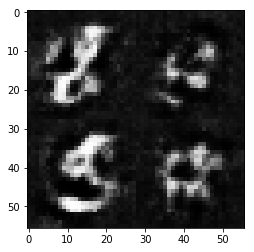

Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 1.9041
Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 1.9301
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 1.8707
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 1.2573
Epoch 1/2... Discriminator Loss: 1.5130... Generator Loss: 2.1451
Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 1.0386
Epoch 1/2... Discriminator Loss: 2.1209... Generator Loss: 2.1686
Epoch 1/2... Discriminator Loss: 1.1378... Generator Loss: 1.3672
Epoch 1/2... Discriminator Loss: 1.1276... Generator Loss: 0.9227
Epoch 1/2... Discriminator Loss: 1.6082... Generator Loss: 0.4667


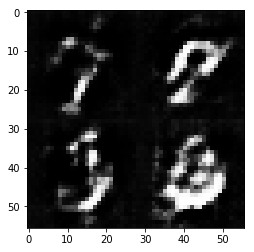

Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 1.5076
Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 1.2557
Epoch 1/2... Discriminator Loss: 1.4868... Generator Loss: 0.3973
Epoch 1/2... Discriminator Loss: 1.5389... Generator Loss: 0.4864
Epoch 1/2... Discriminator Loss: 1.6258... Generator Loss: 0.4552
Epoch 1/2... Discriminator Loss: 1.5481... Generator Loss: 0.4824
Epoch 1/2... Discriminator Loss: 1.4291... Generator Loss: 0.5695
Epoch 1/2... Discriminator Loss: 1.5103... Generator Loss: 0.4835
Epoch 1/2... Discriminator Loss: 1.4265... Generator Loss: 0.4856
Epoch 1/2... Discriminator Loss: 1.7446... Generator Loss: 0.3732


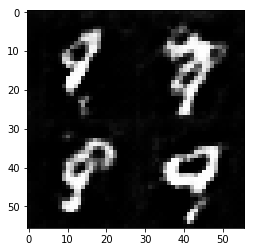

Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 1.6535
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 1.2092
Epoch 1/2... Discriminator Loss: 1.3155... Generator Loss: 1.1011
Epoch 1/2... Discriminator Loss: 1.5942... Generator Loss: 1.6324
Epoch 1/2... Discriminator Loss: 1.5809... Generator Loss: 0.3720
Epoch 1/2... Discriminator Loss: 1.8146... Generator Loss: 0.2952
Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 0.4949
Epoch 1/2... Discriminator Loss: 1.4647... Generator Loss: 0.4732
Epoch 1/2... Discriminator Loss: 1.3900... Generator Loss: 0.6091
Epoch 1/2... Discriminator Loss: 1.8409... Generator Loss: 0.3210


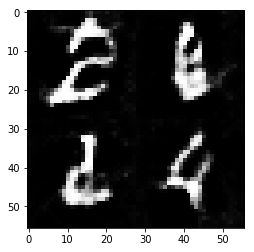

Epoch 1/2... Discriminator Loss: 1.4117... Generator Loss: 0.6537
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.5005
Epoch 1/2... Discriminator Loss: 1.5298... Generator Loss: 0.4013
Epoch 1/2... Discriminator Loss: 1.3437... Generator Loss: 0.5280
Epoch 1/2... Discriminator Loss: 1.5854... Generator Loss: 0.3759
Epoch 1/2... Discriminator Loss: 1.4787... Generator Loss: 0.4776
Epoch 1/2... Discriminator Loss: 1.6206... Generator Loss: 0.4137
Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 0.6497
Epoch 1/2... Discriminator Loss: 1.7514... Generator Loss: 0.3693
Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 0.6953


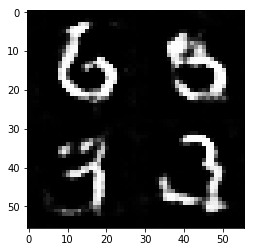

Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 0.9644
Epoch 1/2... Discriminator Loss: 2.2717... Generator Loss: 2.6721
Epoch 1/2... Discriminator Loss: 1.3360... Generator Loss: 1.3136
Epoch 1/2... Discriminator Loss: 1.2651... Generator Loss: 1.1134
Epoch 1/2... Discriminator Loss: 1.5940... Generator Loss: 1.5263
Epoch 1/2... Discriminator Loss: 1.3136... Generator Loss: 0.7727
Epoch 1/2... Discriminator Loss: 1.4221... Generator Loss: 0.6151
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.5266
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 0.4825
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.6040


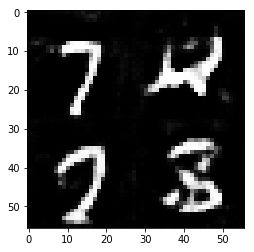

Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 0.5089
Epoch 1/2... Discriminator Loss: 1.5940... Generator Loss: 0.4652
Epoch 1/2... Discriminator Loss: 1.1475... Generator Loss: 1.3299
Epoch 1/2... Discriminator Loss: 1.2684... Generator Loss: 1.1855
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 1.4146
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 1.2331
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.8817
Epoch 1/2... Discriminator Loss: 2.0077... Generator Loss: 0.2213
Epoch 1/2... Discriminator Loss: 1.3781... Generator Loss: 0.6138
Epoch 1/2... Discriminator Loss: 1.3204... Generator Loss: 0.9271


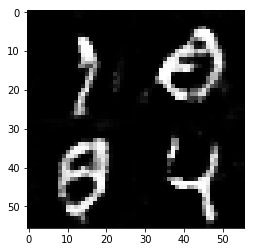

Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 1.7276
Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 1.0226
Epoch 1/2... Discriminator Loss: 1.6816... Generator Loss: 0.3569
Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.4890
Epoch 1/2... Discriminator Loss: 1.5079... Generator Loss: 0.4383
Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.6243
Epoch 1/2... Discriminator Loss: 1.1517... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 1.1362
Epoch 1/2... Discriminator Loss: 1.3313... Generator Loss: 1.2043
Epoch 1/2... Discriminator Loss: 1.1380... Generator Loss: 1.4460


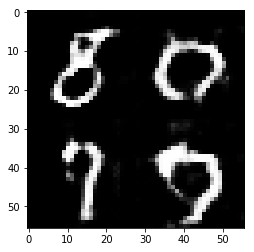

Epoch 1/2... Discriminator Loss: 1.6081... Generator Loss: 1.6514
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 1.4753
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 1.1366
Epoch 2/2... Discriminator Loss: 1.6724... Generator Loss: 0.3753
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.5189
Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.6017
Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.5021
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.4733
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 0.6080
Epoch 2/2... Discriminator Loss: 1.4569... Generator Loss: 0.5588


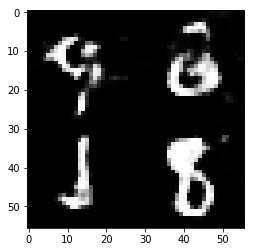

Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.5756
Epoch 2/2... Discriminator Loss: 1.7085... Generator Loss: 0.3574
Epoch 2/2... Discriminator Loss: 1.4746... Generator Loss: 0.3954
Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 0.5250
Epoch 2/2... Discriminator Loss: 1.6471... Generator Loss: 0.3595
Epoch 2/2... Discriminator Loss: 1.3797... Generator Loss: 0.5084
Epoch 2/2... Discriminator Loss: 1.5641... Generator Loss: 0.3849
Epoch 2/2... Discriminator Loss: 1.3992... Generator Loss: 0.5733
Epoch 2/2... Discriminator Loss: 1.2865... Generator Loss: 0.6961
Epoch 2/2... Discriminator Loss: 1.1179... Generator Loss: 1.0656


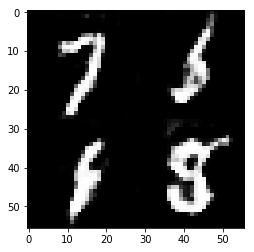

Epoch 2/2... Discriminator Loss: 1.7975... Generator Loss: 2.0602
Epoch 2/2... Discriminator Loss: 1.0151... Generator Loss: 1.0116
Epoch 2/2... Discriminator Loss: 1.5622... Generator Loss: 1.4585
Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 1.0481
Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 0.8506
Epoch 2/2... Discriminator Loss: 1.1937... Generator Loss: 1.4045
Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 1.8532
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 1.3273
Epoch 2/2... Discriminator Loss: 1.1269... Generator Loss: 1.5092
Epoch 2/2... Discriminator Loss: 1.2042... Generator Loss: 0.9818


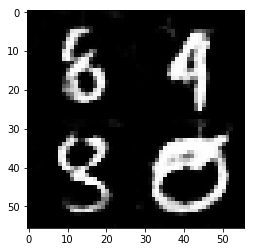

Epoch 2/2... Discriminator Loss: 1.0678... Generator Loss: 1.1903
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 1.9545
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 1.5148
Epoch 2/2... Discriminator Loss: 1.0153... Generator Loss: 1.3076
Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 1.9445
Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 1.0500
Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 1.3129
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 1.5283
Epoch 2/2... Discriminator Loss: 1.0472... Generator Loss: 0.9982


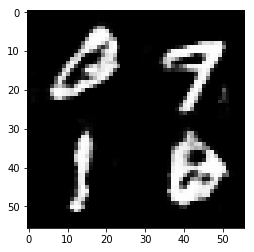

Epoch 2/2... Discriminator Loss: 1.7361... Generator Loss: 2.1322
Epoch 2/2... Discriminator Loss: 1.1067... Generator Loss: 0.6348
Epoch 2/2... Discriminator Loss: 1.1186... Generator Loss: 1.5075
Epoch 2/2... Discriminator Loss: 1.0191... Generator Loss: 0.9867
Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 1.5030
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 1.2685
Epoch 2/2... Discriminator Loss: 1.4627... Generator Loss: 1.5308
Epoch 2/2... Discriminator Loss: 1.1438... Generator Loss: 0.9945
Epoch 2/2... Discriminator Loss: 1.4687... Generator Loss: 1.9530


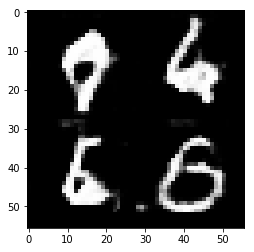

Epoch 2/2... Discriminator Loss: 1.4105... Generator Loss: 0.5436
Epoch 2/2... Discriminator Loss: 1.5965... Generator Loss: 0.4150
Epoch 2/2... Discriminator Loss: 1.0012... Generator Loss: 1.1390
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 1.8717
Epoch 2/2... Discriminator Loss: 1.7276... Generator Loss: 1.9207
Epoch 2/2... Discriminator Loss: 1.0155... Generator Loss: 0.9455
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 1.6412... Generator Loss: 0.3396
Epoch 2/2... Discriminator Loss: 1.3597... Generator Loss: 0.5045
Epoch 2/2... Discriminator Loss: 1.4694... Generator Loss: 1.6172


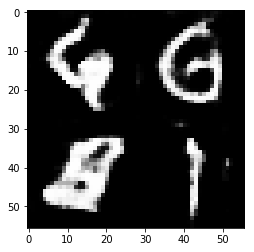

Epoch 2/2... Discriminator Loss: 1.2494... Generator Loss: 1.4371
Epoch 2/2... Discriminator Loss: 1.1062... Generator Loss: 1.4311
Epoch 2/2... Discriminator Loss: 1.6591... Generator Loss: 0.3538
Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 0.5850
Epoch 2/2... Discriminator Loss: 1.4403... Generator Loss: 0.4456
Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 1.0863
Epoch 2/2... Discriminator Loss: 1.9457... Generator Loss: 0.2549
Epoch 2/2... Discriminator Loss: 1.1733... Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 1.6735... Generator Loss: 2.2695
Epoch 2/2... Discriminator Loss: 1.3320... Generator Loss: 1.7248


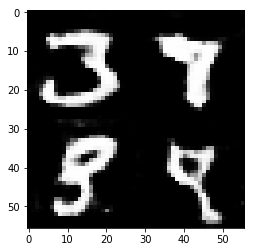

Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 1.8753
Epoch 2/2... Discriminator Loss: 1.1265... Generator Loss: 1.4818
Epoch 2/2... Discriminator Loss: 1.4100... Generator Loss: 1.3944
Epoch 2/2... Discriminator Loss: 1.1228... Generator Loss: 1.0037
Epoch 2/2... Discriminator Loss: 1.0680... Generator Loss: 1.3243
Epoch 2/2... Discriminator Loss: 1.6719... Generator Loss: 0.3513
Epoch 2/2... Discriminator Loss: 1.6030... Generator Loss: 0.3031
Epoch 2/2... Discriminator Loss: 1.1213... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 1.4091... Generator Loss: 0.5958
Epoch 2/2... Discriminator Loss: 1.5319... Generator Loss: 0.4633


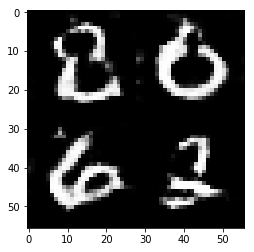

Epoch 2/2... Discriminator Loss: 1.2624... Generator Loss: 0.5529
Epoch 2/2... Discriminator Loss: 1.5431... Generator Loss: 0.5395
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.5602
Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 0.5121
Epoch 2/2... Discriminator Loss: 1.7372... Generator Loss: 0.3758
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 0.4837
Epoch 2/2... Discriminator Loss: 1.7344... Generator Loss: 0.3328
Epoch 2/2... Discriminator Loss: 1.3219... Generator Loss: 0.6857
Epoch 2/2... Discriminator Loss: 1.4524... Generator Loss: 0.4126
Epoch 2/2... Discriminator Loss: 1.5807... Generator Loss: 0.3931


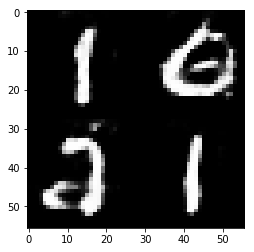

Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 1.3553
Epoch 2/2... Discriminator Loss: 1.1702... Generator Loss: 1.6183
Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 1.0703
Epoch 2/2... Discriminator Loss: 0.9837... Generator Loss: 0.7667
Epoch 2/2... Discriminator Loss: 1.2281... Generator Loss: 0.6103
Epoch 2/2... Discriminator Loss: 1.6460... Generator Loss: 0.3440
Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 1.2452
Finish training


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: -0.2101... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: -0.9400... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: -1.6099... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: -1.8049... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: -2.7907... Generator Loss: 1.6828
Epoch 1/1... Discriminator Loss: -2.4418... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: -3.1865... Generator Loss: 1.9736
Epoch 1/1... Discriminator Loss: -2.5859... Generator Loss: 2.7822
Epoch 1/1... Discriminator Loss: -2.6754... Generator Loss: 4.1337
Epoch 1/1... Discriminator Loss: -1.2070... Generator Loss: 0.0618


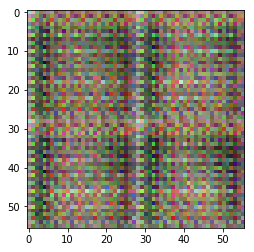

Epoch 1/1... Discriminator Loss: -1.2520... Generator Loss: 0.1280
Epoch 1/1... Discriminator Loss: -1.2193... Generator Loss: 5.7496
Epoch 1/1... Discriminator Loss: -1.0558... Generator Loss: 0.1765
Epoch 1/1... Discriminator Loss: -1.0037... Generator Loss: 0.1942
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 10.6448
Epoch 1/1... Discriminator Loss: -0.9317... Generator Loss: 0.1672
Epoch 1/1... Discriminator Loss: -1.4524... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: -0.4779... Generator Loss: 0.2972
Epoch 1/1... Discriminator Loss: 0.2884... Generator Loss: 0.0845
Epoch 1/1... Discriminator Loss: -1.1589... Generator Loss: 3.6158


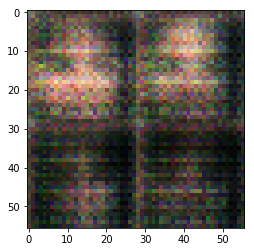

Epoch 1/1... Discriminator Loss: 2.5284... Generator Loss: 7.1804
Epoch 1/1... Discriminator Loss: 0.5573... Generator Loss: 0.2209
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.0250
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 0.0491
Epoch 1/1... Discriminator Loss: -0.3059... Generator Loss: 0.2619
Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 0.2370
Epoch 1/1... Discriminator Loss: -0.9797... Generator Loss: 3.2381
Epoch 1/1... Discriminator Loss: 0.1664... Generator Loss: 4.5836
Epoch 1/1... Discriminator Loss: -0.9281... Generator Loss: 2.3148
Epoch 1/1... Discriminator Loss: 0.1213... Generator Loss: 4.8270


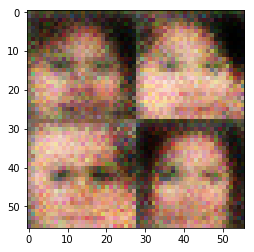

Epoch 1/1... Discriminator Loss: -0.0545... Generator Loss: 4.1267
Epoch 1/1... Discriminator Loss: 0.3756... Generator Loss: 0.0785
Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 0.1518
Epoch 1/1... Discriminator Loss: -0.0134... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 0.0834
Epoch 1/1... Discriminator Loss: -0.1917... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 0.1781
Epoch 1/1... Discriminator Loss: 0.1977... Generator Loss: 0.1790
Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 0.3021
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 0.1891


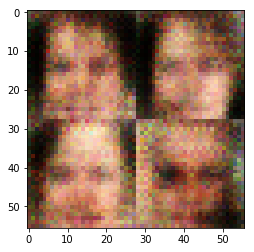

Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.1033
Epoch 1/1... Discriminator Loss: -0.0894... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: -0.0781... Generator Loss: 1.7223
Epoch 1/1... Discriminator Loss: -0.3480... Generator Loss: 1.3547
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 4.4116
Epoch 1/1... Discriminator Loss: -0.9106... Generator Loss: 1.2978
Epoch 1/1... Discriminator Loss: 0.1562... Generator Loss: 2.0192
Epoch 1/1... Discriminator Loss: 0.4291... Generator Loss: 0.1934
Epoch 1/1... Discriminator Loss: 0.1723... Generator Loss: 2.5891
Epoch 1/1... Discriminator Loss: -0.1949... Generator Loss: 2.8455


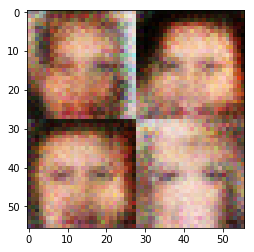

Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 2.7186
Epoch 1/1... Discriminator Loss: -0.0747... Generator Loss: 3.6062
Epoch 1/1... Discriminator Loss: 0.5294... Generator Loss: 2.6568
Epoch 1/1... Discriminator Loss: -0.6685... Generator Loss: 1.3787
Epoch 1/1... Discriminator Loss: -0.2778... Generator Loss: 1.2977
Epoch 1/1... Discriminator Loss: 0.2813... Generator Loss: 2.0505
Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 4.6162
Epoch 1/1... Discriminator Loss: -0.2378... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 0.0533... Generator Loss: 1.4528
Epoch 1/1... Discriminator Loss: -0.0043... Generator Loss: 0.5205


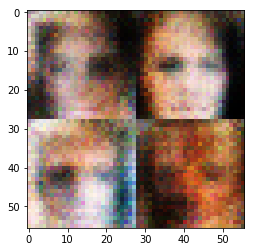

Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 0.3739
Epoch 1/1... Discriminator Loss: 0.0795... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 0.0992... Generator Loss: 1.8832
Epoch 1/1... Discriminator Loss: 1.8113... Generator Loss: 0.0123
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 0.3108
Epoch 1/1... Discriminator Loss: -0.5282... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 0.3034... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 0.0970
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 0.1804


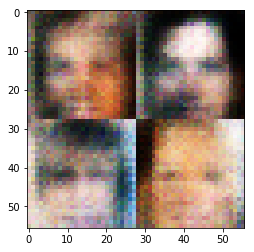

Epoch 1/1... Discriminator Loss: 0.4669... Generator Loss: 0.2497
Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 0.2951
Epoch 1/1... Discriminator Loss: 0.2788... Generator Loss: 2.0521
Epoch 1/1... Discriminator Loss: 0.0666... Generator Loss: 1.4675
Epoch 1/1... Discriminator Loss: 0.0620... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 0.1854... Generator Loss: 0.4461
Epoch 1/1... Discriminator Loss: -0.0612... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 0.2173... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 0.4441... Generator Loss: 0.2596
Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 0.2537


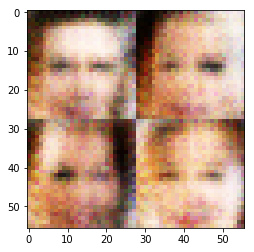

Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 0.4085
Epoch 1/1... Discriminator Loss: -0.0599... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 0.5749... Generator Loss: 0.3938
Epoch 1/1... Discriminator Loss: 0.3042... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 5.6833
Epoch 1/1... Discriminator Loss: 1.6315... Generator Loss: 0.1062
Epoch 1/1... Discriminator Loss: -0.1189... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: -0.0157... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 3.1532
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 0.1795


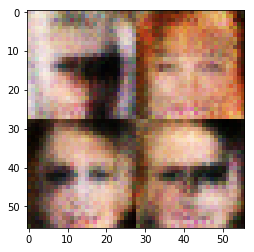

Epoch 1/1... Discriminator Loss: 0.3295... Generator Loss: 0.4029
Epoch 1/1... Discriminator Loss: 0.1051... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 1.1178
Epoch 1/1... Discriminator Loss: 0.6551... Generator Loss: 0.3630
Epoch 1/1... Discriminator Loss: 0.4625... Generator Loss: 1.7455
Epoch 1/1... Discriminator Loss: -0.1888... Generator Loss: 1.9620
Epoch 1/1... Discriminator Loss: 0.1218... Generator Loss: 1.6824
Epoch 1/1... Discriminator Loss: 0.0314... Generator Loss: 1.6967
Epoch 1/1... Discriminator Loss: 0.0619... Generator Loss: 1.1781
Epoch 1/1... Discriminator Loss: 0.5241... Generator Loss: 0.4511


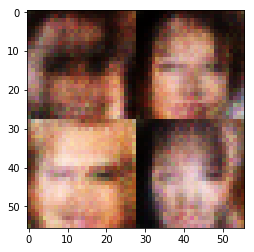

Epoch 1/1... Discriminator Loss: 0.0704... Generator Loss: 2.2260
Epoch 1/1... Discriminator Loss: 0.2774... Generator Loss: 1.6164
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 1.9976
Epoch 1/1... Discriminator Loss: 0.3335... Generator Loss: 1.7470
Epoch 1/1... Discriminator Loss: -0.0542... Generator Loss: 3.0528
Epoch 1/1... Discriminator Loss: 0.0226... Generator Loss: 2.2159
Epoch 1/1... Discriminator Loss: 0.0994... Generator Loss: 2.3586
Epoch 1/1... Discriminator Loss: 0.2551... Generator Loss: 2.5567
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 1.9990
Epoch 1/1... Discriminator Loss: 0.3055... Generator Loss: 2.3273


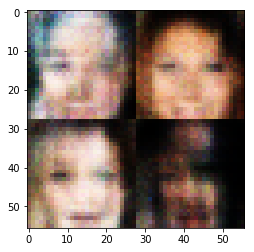

Epoch 1/1... Discriminator Loss: 0.0660... Generator Loss: 1.2734
Epoch 1/1... Discriminator Loss: -0.0045... Generator Loss: 1.9102
Epoch 1/1... Discriminator Loss: 0.1993... Generator Loss: 1.5618
Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 0.3873
Epoch 1/1... Discriminator Loss: 0.4649... Generator Loss: 0.3216
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 0.2642
Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 0.1430
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 0.3301
Epoch 1/1... Discriminator Loss: 0.2022... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: -0.0826... Generator Loss: 0.7842


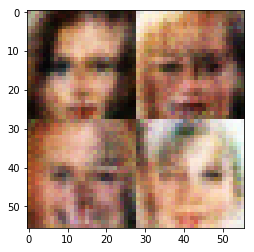

Epoch 1/1... Discriminator Loss: -0.0565... Generator Loss: 0.3660
Epoch 1/1... Discriminator Loss: 0.4834... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 0.4832... Generator Loss: 1.8213
Epoch 1/1... Discriminator Loss: -0.1284... Generator Loss: 2.0455
Epoch 1/1... Discriminator Loss: -0.1457... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 0.2777... Generator Loss: 2.6623
Epoch 1/1... Discriminator Loss: 0.4481... Generator Loss: 1.8524
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 0.2878
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 3.1730
Epoch 1/1... Discriminator Loss: 0.5011... Generator Loss: 0.4065


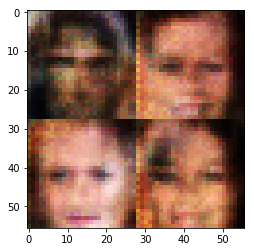

Epoch 1/1... Discriminator Loss: 0.2218... Generator Loss: 1.6280
Epoch 1/1... Discriminator Loss: 0.2750... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 2.5479
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.1708
Epoch 1/1... Discriminator Loss: 0.4157... Generator Loss: 3.0247
Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.1678
Epoch 1/1... Discriminator Loss: 0.1027... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 0.1154... Generator Loss: 1.6397
Epoch 1/1... Discriminator Loss: 0.0718... Generator Loss: 1.3454
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 1.2032


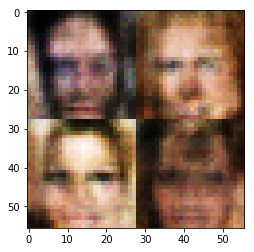

Epoch 1/1... Discriminator Loss: 0.1381... Generator Loss: 1.9447
Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 1.3754
Epoch 1/1... Discriminator Loss: 1.6085... Generator Loss: 0.1618
Epoch 1/1... Discriminator Loss: 0.6455... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 2.7340
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 0.3195
Epoch 1/1... Discriminator Loss: 0.1592... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 0.0995... Generator Loss: 1.1992
Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 0.3906
Epoch 1/1... Discriminator Loss: 0.1575... Generator Loss: 0.8028


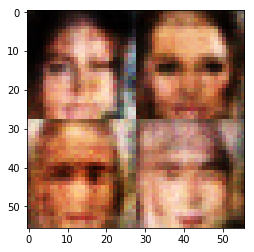

Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 2.5683
Epoch 1/1... Discriminator Loss: 0.1123... Generator Loss: 1.5161
Epoch 1/1... Discriminator Loss: 0.2552... Generator Loss: 1.5163
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 0.3773
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 0.1742
Epoch 1/1... Discriminator Loss: 0.3114... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 0.1487
Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 1.8518
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 2.6621


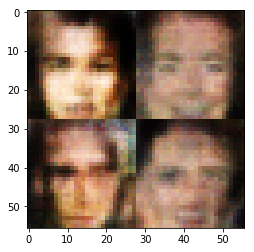

Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.1665
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.8660
Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 0.1593... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 0.2234... Generator Loss: 1.3576
Epoch 1/1... Discriminator Loss: 0.1574... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 1.3572
Epoch 1/1... Discriminator Loss: 0.4179... Generator Loss: 1.3500
Epoch 1/1... Discriminator Loss: 0.5095... Generator Loss: 0.8608


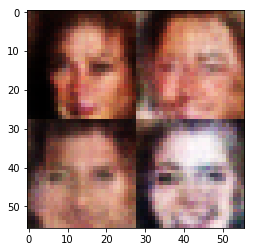

Epoch 1/1... Discriminator Loss: 0.4324... Generator Loss: 1.1200
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.6002
Epoch 1/1... Discriminator Loss: 0.4338... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 1.5313
Epoch 1/1... Discriminator Loss: 0.2287... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 1.4328
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 0.2281
Epoch 1/1... Discriminator Loss: 0.6902... Generator Loss: 0.4641
Epoch 1/1... Discriminator Loss: 0.4267... Generator Loss: 1.8477


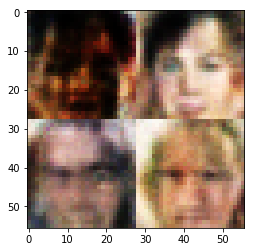

Epoch 1/1... Discriminator Loss: 0.3680... Generator Loss: 1.9006
Epoch 1/1... Discriminator Loss: 0.0741... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 0.7063... Generator Loss: 1.1953
Epoch 1/1... Discriminator Loss: 0.3895... Generator Loss: 1.6519
Epoch 1/1... Discriminator Loss: 0.6062... Generator Loss: 1.3847
Epoch 1/1... Discriminator Loss: 0.2540... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 0.5815... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 0.2580... Generator Loss: 0.4554
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 0.3966


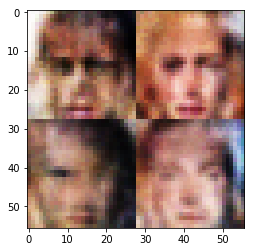

Epoch 1/1... Discriminator Loss: 0.6310... Generator Loss: 1.1433
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.2198
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.6221
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 2.1633
Epoch 1/1... Discriminator Loss: 0.3312... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 0.4626... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.0654
Epoch 1/1... Discriminator Loss: 0.5657... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 0.4287... Generator Loss: 0.5820


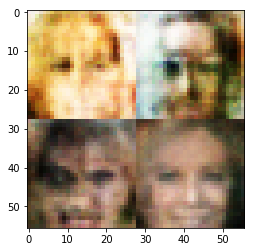

Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 1.3498
Epoch 1/1... Discriminator Loss: 0.6147... Generator Loss: 1.4977
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 2.4233
Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 1.8272
Epoch 1/1... Discriminator Loss: 0.2686... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 0.3072
Epoch 1/1... Discriminator Loss: 0.6067... Generator Loss: 0.3884
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 0.4105


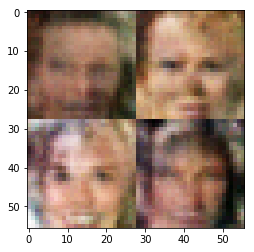

Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 0.1999
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 0.3835
Epoch 1/1... Discriminator Loss: 0.2568... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.4862
Epoch 1/1... Discriminator Loss: 0.4183... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 1.8173
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 1.1030
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 0.5618


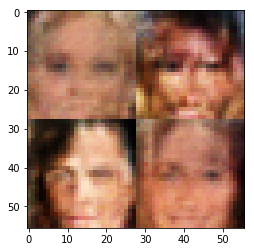

Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.1589
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.2178
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.2262
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.2414
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 0.4543
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.3416
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 0.6669... Generator Loss: 1.4319


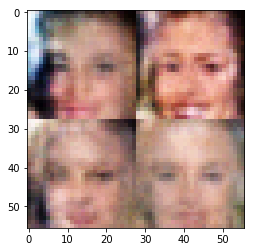

Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 0.5994... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 0.1426
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 0.1799
Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 1.1661
Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.4356


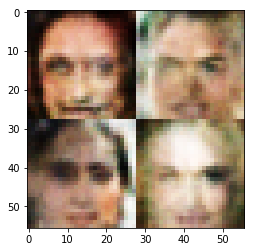

Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 2.0162
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 1.2531
Epoch 1/1... Discriminator Loss: 0.5764... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 2.0978
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 0.3966
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 1.4536


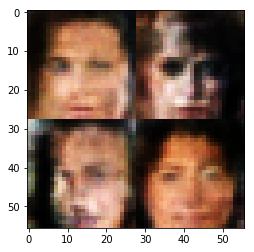

Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 1.2335
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 0.3916
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.4378
Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.2704
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.2811
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 0.5636


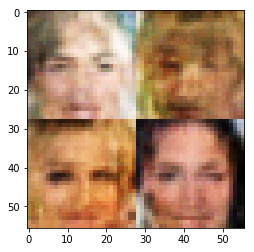

Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.1813
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 1.7843
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 0.5838... Generator Loss: 1.3935
Epoch 1/1... Discriminator Loss: 0.7367... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 0.4629... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 2.0275


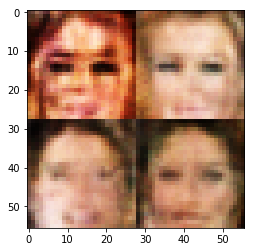

Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.3039
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.5053
Epoch 1/1... Discriminator Loss: 0.2829... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 0.5033... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 1.9819
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 1.2803


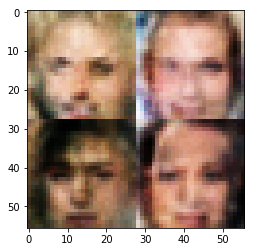

Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 1.4943
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.2784
Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 1.1340
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 0.3411
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 0.5815... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 0.4954


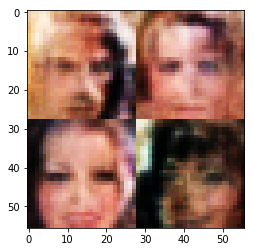

Epoch 1/1... Discriminator Loss: 0.5876... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 1.2278
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.1425
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 1.4493
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.0971
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.0869
Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.6666
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 0.5429


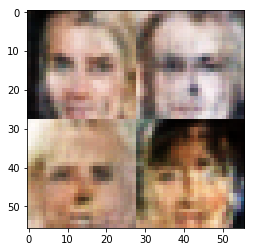

Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.4577
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 0.4070
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.2100
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 1.5038
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 0.3022... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 1.3646


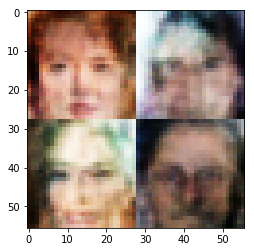

Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 0.5319... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 0.3598
Epoch 1/1... Discriminator Loss: 0.8115... Generator Loss: 1.6088
Epoch 1/1... Discriminator Loss: 0.6683... Generator Loss: 1.2034
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 1.1584


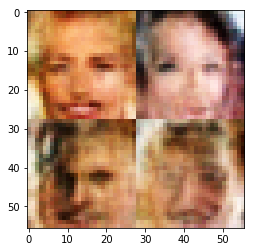

Epoch 1/1... Discriminator Loss: 0.7207... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.2870
Epoch 1/1... Discriminator Loss: 0.5973... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 0.4328... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 0.2856
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.2337
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 0.4280
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.3453
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 1.1115


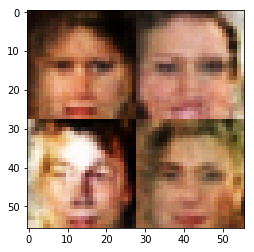

Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 0.3443
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.2881
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 0.1762
Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 0.3131
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 0.6334... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 0.3701


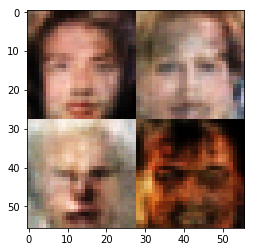

Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.3263
Epoch 1/1... Discriminator Loss: 0.6191... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 0.2578
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.2509
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.2381
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 0.6709... Generator Loss: 0.6218


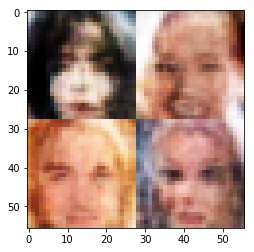

Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 1.2860
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.3015
Epoch 1/1... Discriminator Loss: 0.7842... Generator Loss: 0.2393
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 0.1738
Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 0.6272... Generator Loss: 1.3327


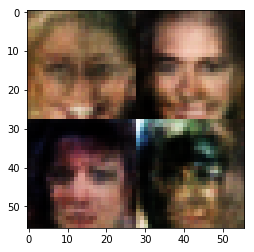

Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.1875
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.7311
Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 0.4538
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.3605
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 0.2767
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 1.2279
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 0.5833... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.3344


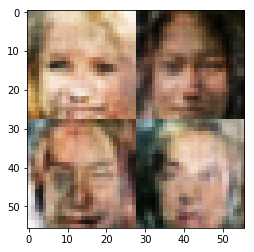

Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.2557
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 1.1676
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 0.4906... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.3365
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 0.7313


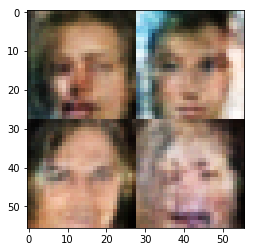

Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 1.3507
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 1.2825
Epoch 1/1... Discriminator Loss: 0.7413... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.1751
Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 0.7779... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 0.8449


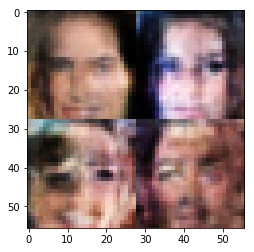

Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 0.3616
Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 0.4021
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.4083
Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 0.2089
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.2999
Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 0.7674


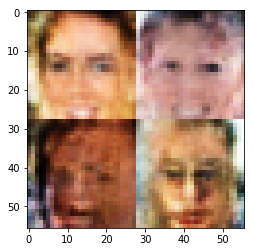

Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 1.3314
Epoch 1/1... Discriminator Loss: 0.5879... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 0.3940
Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 1.0412


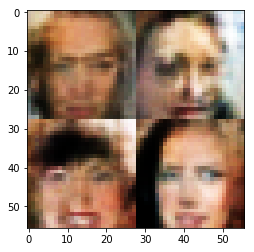

Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 1.6452
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 0.4717... Generator Loss: 0.3469
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.2509
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 1.4026
Epoch 1/1... Discriminator Loss: 0.6968... Generator Loss: 0.3518
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 0.4046
Epoch 1/1... Discriminator Loss: 0.4372... Generator Loss: 1.1429


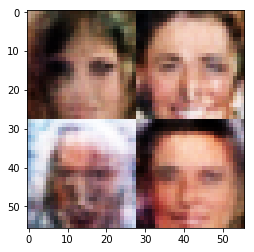

Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 1.5659
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 0.6795... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 0.8890


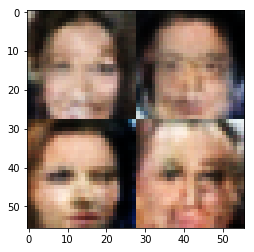

Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.6796
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.2592
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 0.7152... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 0.6980... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.3898
Epoch 1/1... Discriminator Loss: 0.4512... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 0.4126


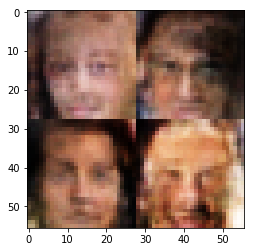

Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 0.4371... Generator Loss: 0.3296
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.2368
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 0.4687
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 0.7413


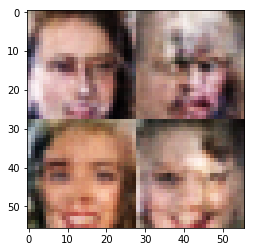

Epoch 1/1... Discriminator Loss: 0.3558... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 0.4684
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.1764
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.4601
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 0.6063


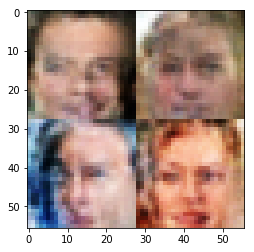

Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.3006
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 0.3775
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 0.5999... Generator Loss: 0.2539
Epoch 1/1... Discriminator Loss: 0.7750... Generator Loss: 1.2458
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 0.3390
Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 0.3197
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 0.3620... Generator Loss: 0.7905


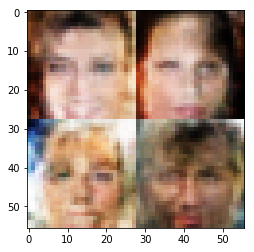

Epoch 1/1... Discriminator Loss: 0.7798... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 0.4197
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 0.2640
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 0.4953... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.4838


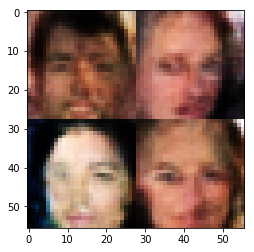

Epoch 1/1... Discriminator Loss: 0.4484... Generator Loss: 1.1816
Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 0.2246
Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.3897
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.3997
Epoch 1/1... Discriminator Loss: 0.7940... Generator Loss: 0.3897
Epoch 1/1... Discriminator Loss: 0.3808... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 0.4999


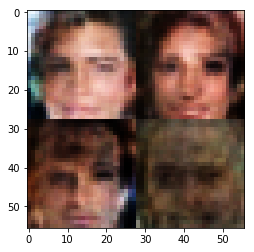

Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 0.3386
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 0.3174
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 2.2776
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 0.3060
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 0.6357... Generator Loss: 0.4837


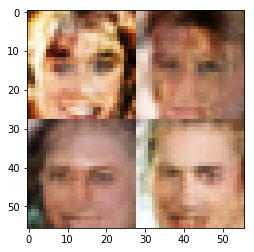

Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 0.2752
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.2247
Epoch 1/1... Discriminator Loss: 0.7300... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.4881
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.2598
Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 0.8334


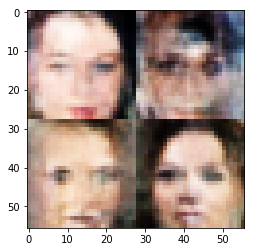

Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 0.3766
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.2295
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 0.3686
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 0.3625


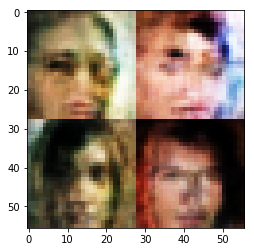

Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.1479
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.1179
Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 0.3688
Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.1680
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 0.6398


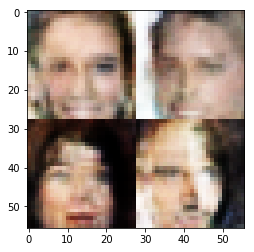

Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 0.4838
Epoch 1/1... Discriminator Loss: 0.4051... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 0.2706... Generator Loss: 1.3080
Epoch 1/1... Discriminator Loss: 0.4880... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 0.6864... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 0.4012
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 0.7012... Generator Loss: 1.3698


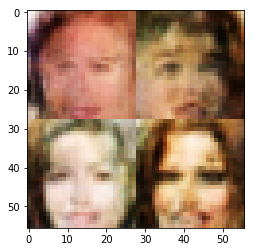

Epoch 1/1... Discriminator Loss: 0.4373... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.3360
Epoch 1/1... Discriminator Loss: 0.4629... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 0.6217... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.2983
Epoch 1/1... Discriminator Loss: 1.7362... Generator Loss: 0.0807
Epoch 1/1... Discriminator Loss: 0.4260... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 0.3590
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 1.6698


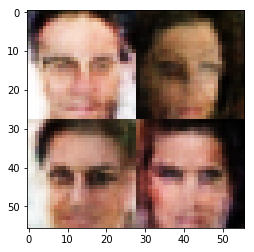

Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 0.4240
Epoch 1/1... Discriminator Loss: 1.7220... Generator Loss: 0.1017
Epoch 1/1... Discriminator Loss: 0.2250... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.3564
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.2435
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.4062
Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 1.2195
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.5601
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 0.5808


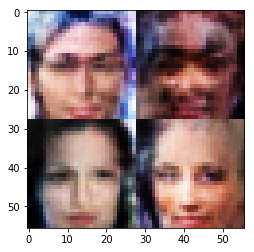

Epoch 1/1... Discriminator Loss: 0.5412... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.1323
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 0.7367... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.2110
Epoch 1/1... Discriminator Loss: 0.7750... Generator Loss: 0.5225


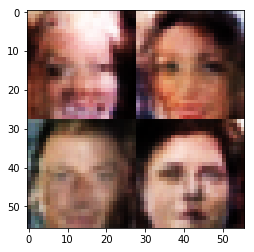

Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 0.4846
Epoch 1/1... Discriminator Loss: 0.4310... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.3557
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 0.3622
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 1.3711
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.4093
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 0.1866
Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 0.2552


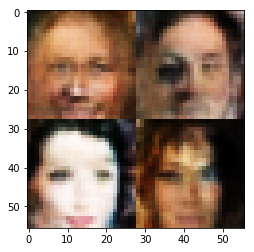

Epoch 1/1... Discriminator Loss: 0.4203... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 0.1674
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 1.3898
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 1.8002
Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 0.5406


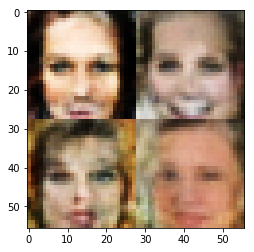

Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.2943
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 0.3056
Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 0.3763... Generator Loss: 1.2117
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 0.3343
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 0.3400
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 0.4135... Generator Loss: 1.0140


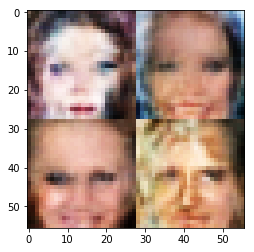

Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 0.2952
Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 0.5597... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 0.4687... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.3489
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.4541


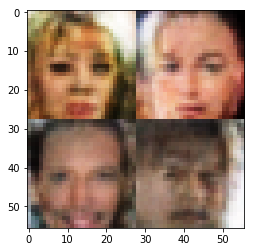

Epoch 1/1... Discriminator Loss: 0.6587... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 0.2613... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.2752
Epoch 1/1... Discriminator Loss: 0.4475... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 0.3636
Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.4358
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 1.5411


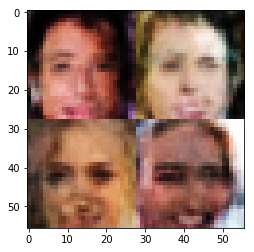

Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.4489
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.1788
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 0.2788... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 0.6702... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 0.7266... Generator Loss: 1.2770
Epoch 1/1... Discriminator Loss: 0.8849... Generator Loss: 0.1823
Epoch 1/1... Discriminator Loss: 0.4336... Generator Loss: 0.6530


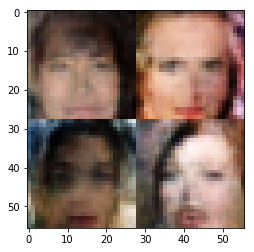

Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 0.3621
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 0.9036
Finish training


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.